In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin
from kdelearn.metrics import pi_kf

# Dane

Parametry mieszaniny rozkładów Gaussa używanych w dalszych przykładach:

$$
seed=1
$$

$$
m=1000
$$

$$
m_1=0.25m
$$

\begin{equation*}
E_1 =
\left(\begin{array}{c}
-3 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_1 =
\left(\begin{array}{cc}\ 
4 & -1.4\\
-1.4 & 1
\end{array}\right)
\end{equation*}


$$
m_2=0.5m
$$

\begin{equation*}
E_2 =
\left(\begin{array}{c}
2 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_2 =
\left(\begin{array}{cc}\ 
1 & 0.7\\
0.7 & 1
\end{array}\right)
\end{equation*}


$$
m_3=0.15m
$$

\begin{equation*}
E_3 =
\left(\begin{array}{c}
5 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_3 =
\left(\begin{array}{cc}\ 
1 & 0.9\\
0.9 & 1
\end{array}\right)
\end{equation*}


$$
m_4=0.1m
$$

\begin{equation*}
E_4 =
\left(\begin{array}{c}
0 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_4 =
\left(\begin{array}{cc}\ 
16 & 0\\
0 & 4
\end{array}\right)
\end{equation*}

Uwaga: Dane z 4 członu to traktowane są jako szum

## Treningowe

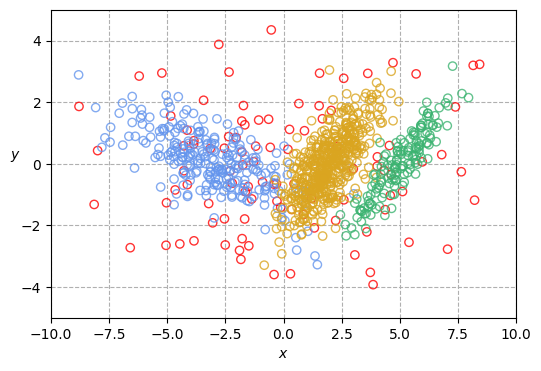

In [3]:
np.random.seed(1)

# Data
n_experiments = 5  # 100
m_train = 1000
n_x, n_y = 1, 1

# Class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
# Class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
# Class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
# Class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]

z_train = np.empty((n_experiments, m_train, n_x + n_y))
labels_train1 = np.full(m_train1, 1, dtype=np.int32)
labels_train2 = np.full(m_train2, 2, dtype=np.int32)
labels_train3 = np.full(m_train3, 3, dtype=np.int32)
labels_train4 = np.full(m_train4, 4, dtype=np.int32)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

for e in range(n_experiments):
    # Class 1
    z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
    # Class 2
    z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
    # Class 3
    z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
    # Class 4
    z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)

    z_train[e, :, :] = np.concatenate((z_train1, z_train2, z_train3, z_train4), axis=0)

x_train = z_train[:, :, [0]]
y_train = z_train[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, -m_train4:], y_train[0, -m_train4:], facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

In [4]:
bandwidth_z = np.zeros((n_experiments, n_x + n_y))
for e in range(n_experiments):
    bandwidth_z[e] = direct_plugin(z_train[e])
bandwidth_x = bandwidth_z[:, :n_x]
bandwidth_y = bandwidth_z[:, n_x:]

x_grid = np.linspace(-10, 10, 1000)[:, None]

# Ujęcie bezwarunkowe (r=0.1)

Do detekcji elementów nietypowych stosowana jest metoda podstawień rzędu 2.

## Pojedynczy eksperyment

Wskaźnik jakości (PI_kf): 0.517670


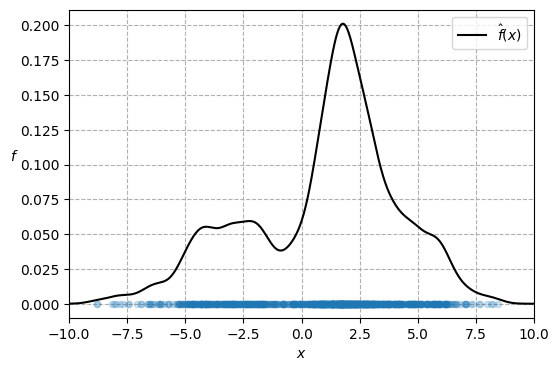

In [5]:
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0])
scores = kde_outlier_detector.kde.pdf(x_grid)
labels_pred = kde_outlier_detector.predict(x_train[0])

metric = pi_kf(x_train[0], x_train[0], labels_pred)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")


true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

# plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
# plt.hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, :], x_train[0, :]*0, s=20, alpha=0.2, zorder=2)
# plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, s=20, alpha=0.2, zorder=2)
# plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

In [7]:
# h multiplier: [0.5, 0.6, ..., 1.5]
# r: [0.01, 0.02, ..., 0.2]


h_mul=0.50 

r=0.01
Wskaźnik jakości (PI_kf): 0.6416632078
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.4167552970
r=0.04
Wskaźnik jakości (PI_kf): 0.3376602799
r=0.05
Wskaźnik jakości (PI_kf): 0.3468420268
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4500193707
r=0.08
Wskaźnik jakości (PI_kf): 0.4841328835
r=0.09
Wskaźnik jakości (PI_kf): 0.5105963116
r=0.10
Wskaźnik jakości (PI_kf): 0.5271465406
r=0.11
Wskaźnik jakości (PI_kf): 0.5378398401
r=0.12
Wskaźnik jakości (PI_kf): 0.5515489810
r=0.13
Wskaźnik jakości (PI_kf): 0.5738012364
r=0.14
Wskaźnik jakości (PI_kf): 0.5927639513
r=0.15
Wskaźnik jakości (PI_kf): 0.6047437339
r=0.16
Wskaźnik jakości (PI_kf): 0.6256826081
r=0.17
Wskaźnik jakości (PI_kf): 0.6365769837
r=0.18
Wskaźnik jakości (PI_kf): 0.6441653297
r=0.19
Wskaźnik jakości (PI_kf): 0.6563434606
r=0.20
Wskaźnik jakości (PI_kf): 0.6636914011
best_r=0.04 !!!!!!!


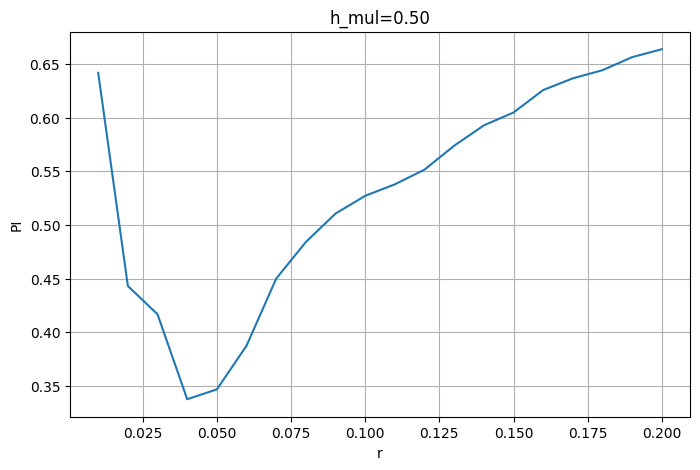


h_mul=0.60 

r=0.01
Wskaźnik jakości (PI_kf): 0.6416632078
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.4167552970
r=0.04
Wskaźnik jakości (PI_kf): 0.3376602799
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4425362068
r=0.08
Wskaźnik jakości (PI_kf): 0.4815564856
r=0.09
Wskaźnik jakości (PI_kf): 0.5054385884
r=0.10
Wskaźnik jakości (PI_kf): 0.5256821569
r=0.11
Wskaźnik jakości (PI_kf): 0.5358819262
r=0.12
Wskaźnik jakości (PI_kf): 0.5498529593
r=0.13
Wskaźnik jakości (PI_kf): 0.5652863580
r=0.14
Wskaźnik jakości (PI_kf): 0.5858807713
r=0.15
Wskaźnik jakości (PI_kf): 0.6020250464
r=0.16
Wskaźnik jakości (PI_kf): 0.6129799886
r=0.17
Wskaźnik jakości (PI_kf): 0.6213673422
r=0.18
Wskaźnik jakości (PI_kf): 0.6344106191
r=0.19
Wskaźnik jakości (PI_kf): 0.6436929297
r=0.20
Wskaźnik jakości (PI_kf): 0.6556794732
best_r=0.04 !!!!!!!


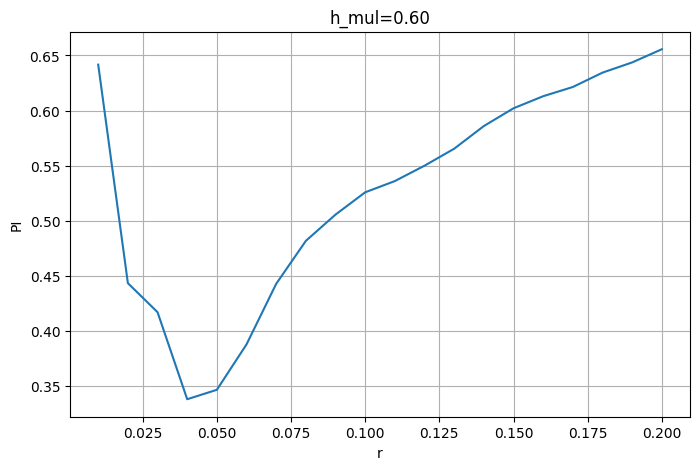


h_mul=0.70 

r=0.01
Wskaźnik jakości (PI_kf): 0.6057094532
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.3862037696
r=0.04
Wskaźnik jakości (PI_kf): 0.3341980871
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4425362068
r=0.08
Wskaźnik jakości (PI_kf): 0.4815564856
r=0.09
Wskaźnik jakości (PI_kf): 0.5054385884
r=0.10
Wskaźnik jakości (PI_kf): 0.5217929554
r=0.11
Wskaźnik jakości (PI_kf): 0.5343341880
r=0.12
Wskaźnik jakości (PI_kf): 0.5486298606
r=0.13
Wskaźnik jakości (PI_kf): 0.5642205821
r=0.14
Wskaźnik jakości (PI_kf): 0.5799331176
r=0.15
Wskaźnik jakości (PI_kf): 0.5924608901
r=0.16
Wskaźnik jakości (PI_kf): 0.6080703661
r=0.17
Wskaźnik jakości (PI_kf): 0.6166355722
r=0.18
Wskaźnik jakości (PI_kf): 0.6229847498
r=0.19
Wskaźnik jakości (PI_kf): 0.6309311602
r=0.20
Wskaźnik jakości (PI_kf): 0.6378611653
best_r=0.04 !!!!!!!


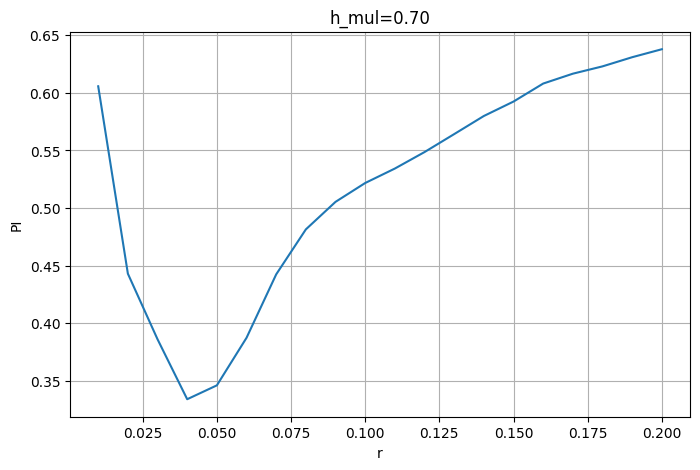


h_mul=0.80 

r=0.01
Wskaźnik jakości (PI_kf): 0.5888465931
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.3862037696
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4392689187
r=0.08
Wskaźnik jakości (PI_kf): 0.4759163957
r=0.09
Wskaźnik jakości (PI_kf): 0.5012324260
r=0.10
Wskaźnik jakości (PI_kf): 0.5191508041
r=0.11
Wskaźnik jakości (PI_kf): 0.5343341880
r=0.12
Wskaźnik jakości (PI_kf): 0.5486298606
r=0.13
Wskaźnik jakości (PI_kf): 0.5642205821
r=0.14
Wskaźnik jakości (PI_kf): 0.5787162480
r=0.15
Wskaźnik jakości (PI_kf): 0.5904384628
r=0.16
Wskaźnik jakości (PI_kf): 0.6006890763
r=0.17
Wskaźnik jakości (PI_kf): 0.6118305571
r=0.18
Wskaźnik jakości (PI_kf): 0.6207754594
r=0.19
Wskaźnik jakości (PI_kf): 0.6284543274
r=0.20
Wskaźnik jakości (PI_kf): 0.6366863219
best_r=0.04 !!!!!!!


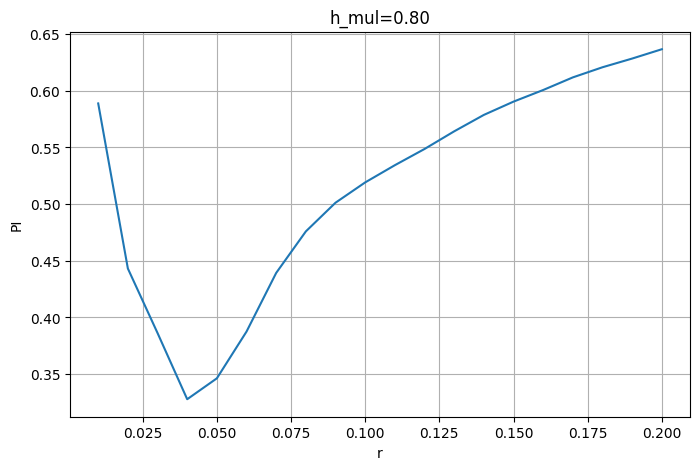


h_mul=0.90 

r=0.01
Wskaźnik jakości (PI_kf): 0.5801408954
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.3839560019
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4349402431
r=0.08
Wskaźnik jakości (PI_kf): 0.4738832901
r=0.09
Wskaźnik jakości (PI_kf): 0.4994099936
r=0.10
Wskaźnik jakości (PI_kf): 0.5183908796
r=0.11
Wskaźnik jakości (PI_kf): 0.5331051901
r=0.12
Wskaźnik jakości (PI_kf): 0.5481788745
r=0.13
Wskaźnik jakości (PI_kf): 0.5630202449
r=0.14
Wskaźnik jakości (PI_kf): 0.5762420432
r=0.15
Wskaźnik jakości (PI_kf): 0.5896660930
r=0.16
Wskaźnik jakości (PI_kf): 0.6003412374
r=0.17
Wskaźnik jakości (PI_kf): 0.6096245661
r=0.18
Wskaźnik jakości (PI_kf): 0.6187414202
r=0.19
Wskaźnik jakości (PI_kf): 0.6276681173
r=0.20
Wskaźnik jakości (PI_kf): 0.6355078997
best_r=0.04 !!!!!!!


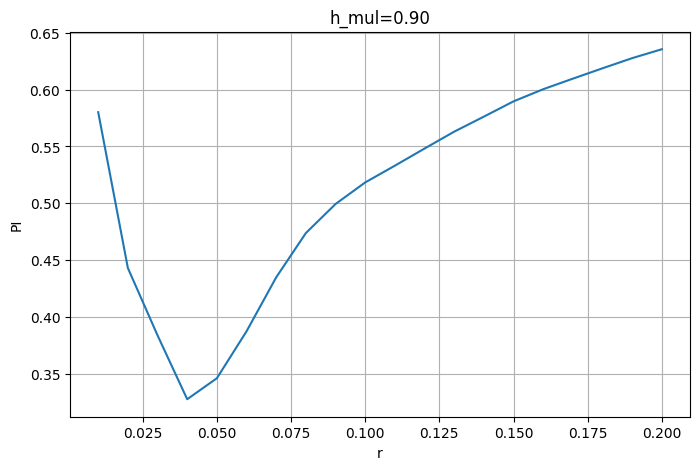


h_mul=1.00 

r=0.01
Wskaźnik jakości (PI_kf): 0.5801408954
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.3839560019
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4341931685
r=0.08
Wskaźnik jakości (PI_kf): 0.4722542034
r=0.09
Wskaźnik jakości (PI_kf): 0.4986279892
r=0.10
Wskaźnik jakości (PI_kf): 0.5176697834
r=0.11
Wskaźnik jakości (PI_kf): 0.5328627147
r=0.12
Wskaźnik jakości (PI_kf): 0.5476839298
r=0.13
Wskaźnik jakości (PI_kf): 0.5623539020
r=0.14
Wskaźnik jakości (PI_kf): 0.5759870056
r=0.15
Wskaźnik jakości (PI_kf): 0.5889882356
r=0.16
Wskaźnik jakości (PI_kf): 0.6001333421
r=0.17
Wskaźnik jakości (PI_kf): 0.6095835651
r=0.18
Wskaźnik jakości (PI_kf): 0.6185156463
r=0.19
Wskaźnik jakości (PI_kf): 0.6273172795
r=0.20
Wskaźnik jakości (PI_kf): 0.6355078997
best_r=0.04 !!!!!!!


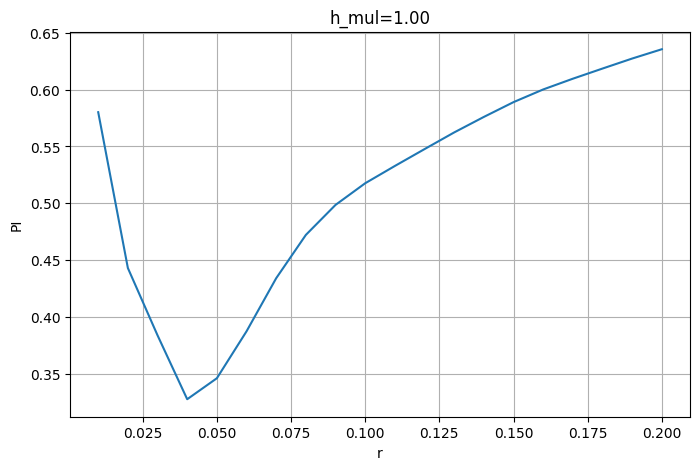


h_mul=1.10 

r=0.01
Wskaźnik jakości (PI_kf): 0.5801408954
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.3846183649
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4341931685
r=0.08
Wskaźnik jakości (PI_kf): 0.4740409548
r=0.09
Wskaźnik jakości (PI_kf): 0.4989561597
r=0.10
Wskaźnik jakości (PI_kf): 0.5182046718
r=0.11
Wskaźnik jakości (PI_kf): 0.5333203673
r=0.12
Wskaźnik jakości (PI_kf): 0.5477973983
r=0.13
Wskaźnik jakości (PI_kf): 0.5630264324
r=0.14
Wskaźnik jakości (PI_kf): 0.5765412877
r=0.15
Wskaźnik jakości (PI_kf): 0.5892483296
r=0.16
Wskaźnik jakości (PI_kf): 0.6006674495
r=0.17
Wskaźnik jakości (PI_kf): 0.6098711566
r=0.18
Wskaźnik jakości (PI_kf): 0.6187258205
r=0.19
Wskaźnik jakości (PI_kf): 0.6275081747
r=0.20
Wskaźnik jakości (PI_kf): 0.6357939370
best_r=0.04 !!!!!!!


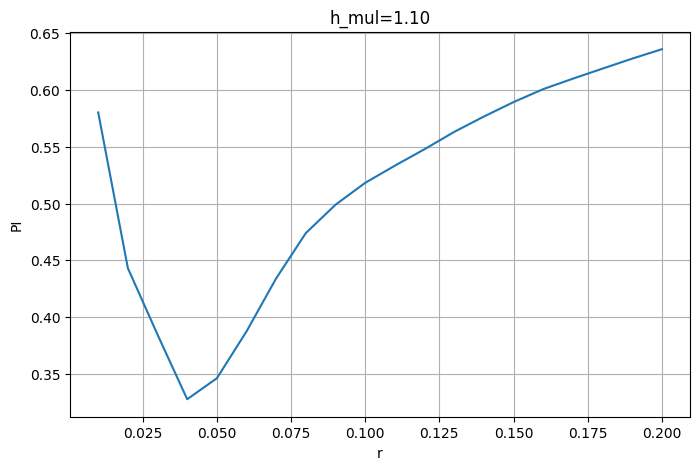


h_mul=1.20 

r=0.01
Wskaźnik jakości (PI_kf): 0.5801408954
r=0.02
Wskaźnik jakości (PI_kf): 0.4431230817
r=0.03
Wskaźnik jakości (PI_kf): 0.3846183649
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4345451132
r=0.08
Wskaźnik jakości (PI_kf): 0.4740409548
r=0.09
Wskaźnik jakości (PI_kf): 0.5023728303
r=0.10
Wskaźnik jakości (PI_kf): 0.5200627483
r=0.11
Wskaźnik jakości (PI_kf): 0.5349864557
r=0.12
Wskaźnik jakości (PI_kf): 0.5507708094
r=0.13
Wskaźnik jakości (PI_kf): 0.5644931678
r=0.14
Wskaźnik jakości (PI_kf): 0.5789791228
r=0.15
Wskaźnik jakości (PI_kf): 0.5910822995
r=0.16
Wskaźnik jakości (PI_kf): 0.6021229937
r=0.17
Wskaźnik jakości (PI_kf): 0.6115131348
r=0.18
Wskaźnik jakości (PI_kf): 0.6210807041
r=0.19
Wskaźnik jakości (PI_kf): 0.6277447288
r=0.20
Wskaźnik jakości (PI_kf): 0.6362353598
best_r=0.04 !!!!!!!


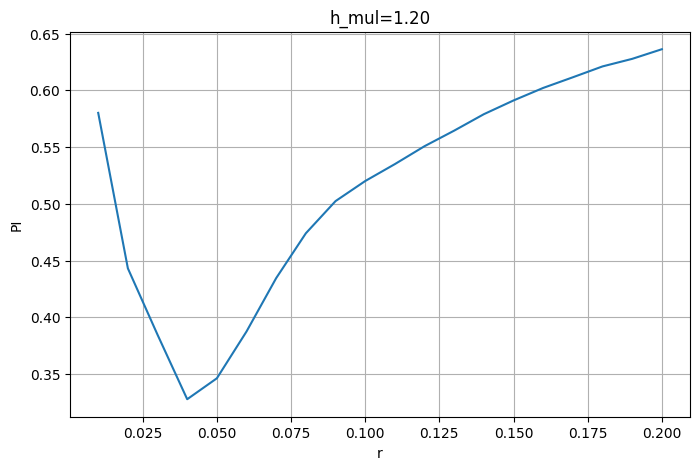


h_mul=1.30 

r=0.01
Wskaźnik jakości (PI_kf): 0.5801408954
r=0.02
Wskaźnik jakości (PI_kf): 0.4496158905
r=0.03
Wskaźnik jakości (PI_kf): 0.3875158790
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3462329207
r=0.06
Wskaźnik jakości (PI_kf): 0.3874952579
r=0.07
Wskaźnik jakości (PI_kf): 0.4345451132
r=0.08
Wskaźnik jakości (PI_kf): 0.4740409548
r=0.09
Wskaźnik jakości (PI_kf): 0.5106793892
r=0.10
Wskaźnik jakości (PI_kf): 0.5257301859
r=0.11
Wskaźnik jakości (PI_kf): 0.5397801597
r=0.12
Wskaźnik jakości (PI_kf): 0.5530265699
r=0.13
Wskaźnik jakości (PI_kf): 0.5676589246
r=0.14
Wskaźnik jakości (PI_kf): 0.5808848659
r=0.15
Wskaźnik jakości (PI_kf): 0.5949426458
r=0.16
Wskaźnik jakości (PI_kf): 0.6054873355
r=0.17
Wskaźnik jakości (PI_kf): 0.6135332366
r=0.18
Wskaźnik jakości (PI_kf): 0.6216578924
r=0.19
Wskaźnik jakości (PI_kf): 0.6310881006
r=0.20
Wskaźnik jakości (PI_kf): 0.6400054173
best_r=0.04 !!!!!!!


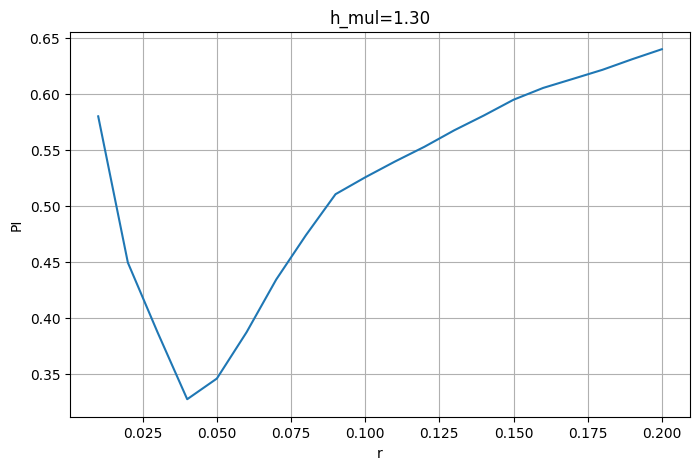


h_mul=1.40 

r=0.01
Wskaźnik jakości (PI_kf): 0.5801408954
r=0.02
Wskaźnik jakości (PI_kf): 0.4496158905
r=0.03
Wskaźnik jakości (PI_kf): 0.3875158790
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3468420268
r=0.06
Wskaźnik jakości (PI_kf): 0.3881322266
r=0.07
Wskaźnik jakości (PI_kf): 0.4351029916
r=0.08
Wskaźnik jakości (PI_kf): 0.4740409548
r=0.09
Wskaźnik jakości (PI_kf): 0.5129610790
r=0.10
Wskaźnik jakości (PI_kf): 0.5430726318
r=0.11
Wskaźnik jakości (PI_kf): 0.5468091949
r=0.12
Wskaźnik jakości (PI_kf): 0.5561799479
r=0.13
Wskaźnik jakości (PI_kf): 0.5721623894
r=0.14
Wskaźnik jakości (PI_kf): 0.5835708543
r=0.15
Wskaźnik jakości (PI_kf): 0.5957315172
r=0.16
Wskaźnik jakości (PI_kf): 0.6087847524
r=0.17
Wskaźnik jakości (PI_kf): 0.6188254804
r=0.18
Wskaźnik jakości (PI_kf): 0.6258415641
r=0.19
Wskaźnik jakości (PI_kf): 0.6345245709
r=0.20
Wskaźnik jakości (PI_kf): 0.6436499214
best_r=0.04 !!!!!!!


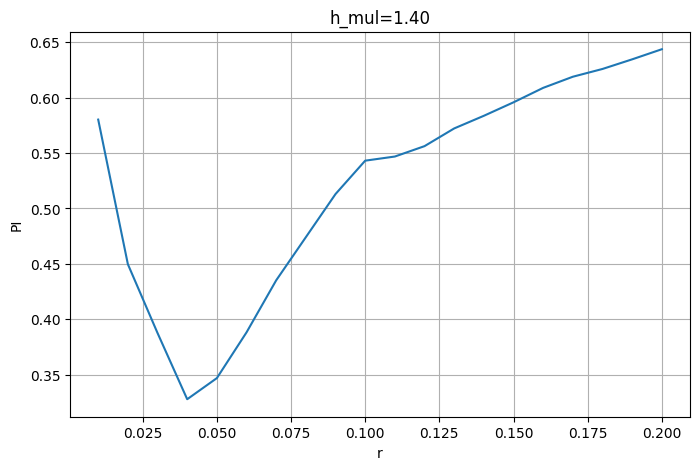


h_mul=1.50 

r=0.01
Wskaźnik jakości (PI_kf): 0.5801408954
r=0.02
Wskaźnik jakości (PI_kf): 0.4496158905
r=0.03
Wskaźnik jakości (PI_kf): 0.3912263542
r=0.04
Wskaźnik jakości (PI_kf): 0.3277850401
r=0.05
Wskaźnik jakości (PI_kf): 0.3468420268
r=0.06
Wskaźnik jakości (PI_kf): 0.3881322266
r=0.07
Wskaźnik jakości (PI_kf): 0.4359123803
r=0.08
Wskaźnik jakości (PI_kf): 0.4740409548
r=0.09
Wskaźnik jakości (PI_kf): 0.5129610790
r=0.10
Wskaźnik jakości (PI_kf): 0.5485492091
r=0.11
Wskaźnik jakości (PI_kf): 0.5688341022
r=0.12
Wskaźnik jakości (PI_kf): 0.5722017148
r=0.13
Wskaźnik jakości (PI_kf): 0.5794985631
r=0.14
Wskaźnik jakości (PI_kf): 0.5894164084
r=0.15
Wskaźnik jakości (PI_kf): 0.6005392075
r=0.16
Wskaźnik jakości (PI_kf): 0.6123292446
r=0.17
Wskaźnik jakości (PI_kf): 0.6208181258
r=0.18
Wskaźnik jakości (PI_kf): 0.6316547134
r=0.19
Wskaźnik jakości (PI_kf): 0.6431934226
r=0.20
Wskaźnik jakości (PI_kf): 0.6532605823
best_r=0.04 !!!!!!!


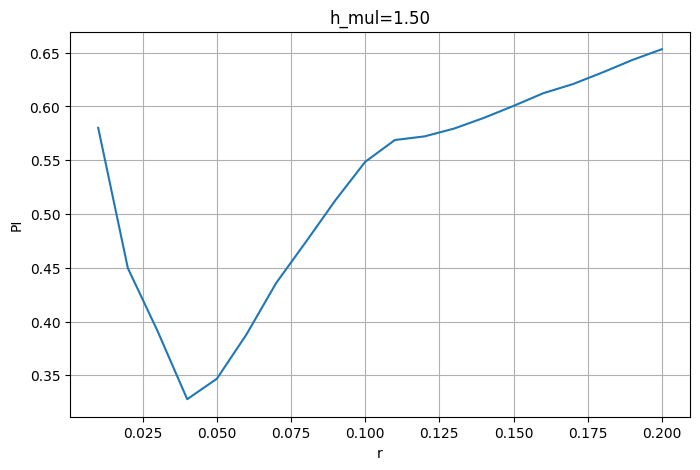

In [9]:
rs = tuple(0.01 * r for r in range(1, 21))
h_muls = tuple(0.1 * h_mul for h_mul in range(5, 16))

for h_mul in h_muls:
    print(f"\n{h_mul=:.2f} \n")
    
    best_r = 999
    best_metrics = 999
    metrics_list = []
    for r in rs:
        print(f"{r=:.2f}")

        kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * h_mul, r=r)
        labels_pred = kde_outlier_detector.predict(x_train[0])
        
        metric = pi_kf(x_train[0], x_train[0], labels_pred)
        metrics_list.append(metric)
        print(f"Wskaźnik jakości (PI_kf): {metric:.10f}")
        if metric < best_metrics:
            best_r = r
            best_metrics = metric
    print(f"{best_r=:.2f} !!!!!!!")

    plt.figure(figsize=(8, 5))
    plt.title(f"{h_mul=:.2f}")
    plt.plot(rs, metrics_list)
    plt.xlabel("r")
    plt.ylabel("PI", rotation=90)
    plt.grid()
    plt.show()

In [11]:
# rs = tuple(0.01 * r for r in range(1, 21))
# h_muls = tuple(0.1 * h_mul for h_mul in range(5, 16))

# for r in rs:
#     print(f"\n{r=:.2f}\n")
    
#     best_h_mul = 999
#     best_metrics = 999
#     metrics_list = []
#     for h_mul in h_muls:
#         print(f"{h_mul=:.2f}")
#         kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * h_mul, r=r)
#         labels_pred = kde_outlier_detector.predict(x_train[0])

#         metric = pi_kf(x_train[0], x_train[0], labels_pred)
#         metrics_list.append(metric)
#         print(f"Wskaźnik jakości (PI_kf): {metric:.10f}")
#         if metric < best_metrics:
#             best_h_mul = h_mul
#             best_metrics = metric
#     print(f"{best_h_mul=:.2f} !!!!!!!")

#     plt.figure(figsize=(8, 5))
#     plt.title(f"{r=}")
#     plt.plot(h_muls, metrics_list)
#     plt.xlabel("h multiplier")
#     plt.ylabel("PI", rotation=90)
#     plt.grid()
#     plt.show()

Wskaźnik jakości (PI_kf): 0.327785


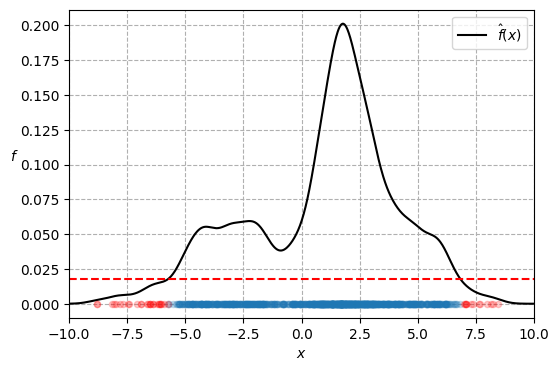

In [8]:
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0], r=0.04)
scores = kde_outlier_detector.kde.pdf(x_grid)
labels_pred = kde_outlier_detector.predict(x_train[0])

metric = pi_kf(x_train[0], x_train[0], labels_pred)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")


true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

# plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
plt.hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, s=20, alpha=0.2, zorder=2)
plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

\newpage

Wskaźnik jakości (PI_kf): 0.625437


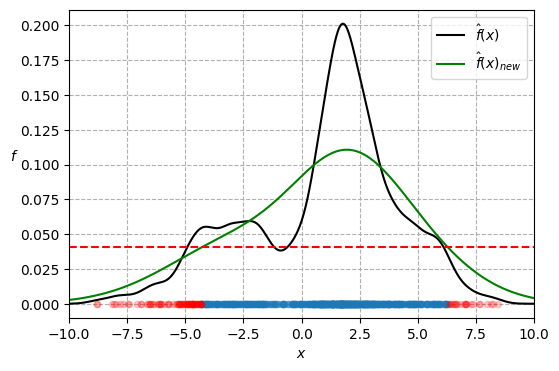

In [6]:
kde_outlier_detector_tmp = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * 5)
scores_tmp = kde_outlier_detector_tmp.kde.pdf(x_grid)
labels_pred_tmp = kde_outlier_detector_tmp.predict(x_train[0])

metric = pi_kf(x_train[0], x_train[0], labels_pred_tmp)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")


true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

# plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
plt.plot(x_grid, scores_tmp, c="green", label="$\hat{f}(x)_{new}$")
plt.hlines(kde_outlier_detector_tmp.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred_tmp==0], x_train[0, labels_pred_tmp==0]*0, s=20, alpha=0.2, zorder=2)
plt.scatter(x_train[0, labels_pred_tmp==1], x_train[0, labels_pred_tmp==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

In [7]:
kde_outlier_detector_tmp.threshold

0.0404140130983623

Wskaźnik jakości (PI_kf): 0.527147


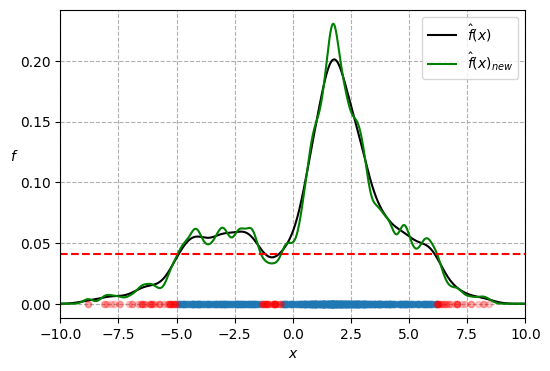

In [8]:
kde_outlier_detector_tmp = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * 0.5)
scores_tmp = kde_outlier_detector_tmp.kde.pdf(x_grid)
labels_pred_tmp = kde_outlier_detector_tmp.predict(x_train[0])

metric = pi_kf(x_train[0], x_train[0], labels_pred_tmp)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")


true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

# plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
plt.plot(x_grid, scores_tmp, c="green", label="$\hat{f}(x)_{new}$")
plt.hlines(kde_outlier_detector_tmp.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred_tmp==0], x_train[0, labels_pred_tmp==0]*0, s=20, alpha=0.2, zorder=2)
plt.scatter(x_train[0, labels_pred_tmp==1], x_train[0, labels_pred_tmp==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

In [9]:
kde_outlier_detector_tmp.threshold

0.0407111470079428

### Dopasowanie $h$ na siatce

In [10]:
fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]

print(f"Mnożniki na siatce: {fac_grid}")

Mnożniki na siatce: [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]


Najlepszy wskaźnik jakości (PI_kf): 0.517670
Dla mnożnika: 1.0


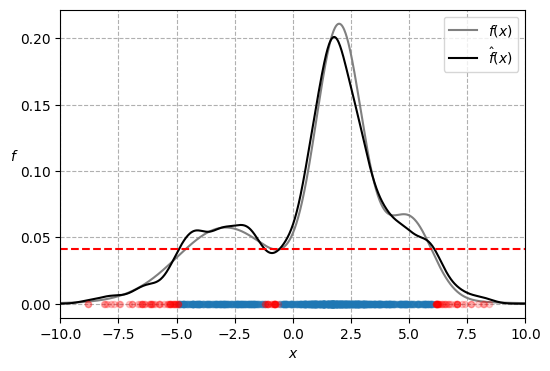

In [11]:
metrics_list = []
for x_fac in fac_grid:
    outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * x_fac)
    labels_pred = outlier_detector.predict(x_train[0])

    metric = pi_kf(x_train[0], x_train[0], labels_pred)
    metrics_list.append(metric)

argmin = np.argmin(metrics_list)
best_bandwidth_multiplier = fac_grid[argmin]

print(f"Najlepszy wskaźnik jakości (PI_kf): {metrics_list[argmin]:.6f}")
print(f"Dla mnożnika: {best_bandwidth_multiplier}")


###
best_bandwidth = bandwidth_x[0] * best_bandwidth_multiplier
best_kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=best_bandwidth)
scores = best_kde_outlier_detector.kde.pdf(x_grid)
labels_pred = best_kde_outlier_detector.predict(x_train[0])


# Plot
true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
plt.hlines(best_kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, s=20, alpha=0.2, zorder=2)
plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

### Dopasowanie $r$ na siatce

In [12]:
r_grid = [0.01, 0.02, 0.05, 0.1, 0.2]

print(f"'r' na siatce: {r_grid}")

'r' na siatce: [0.01, 0.02, 0.05, 0.1, 0.2]


Najlepszy wskaźnik jakości (PI_kf): 0.346233
Dla 'r': 0.05


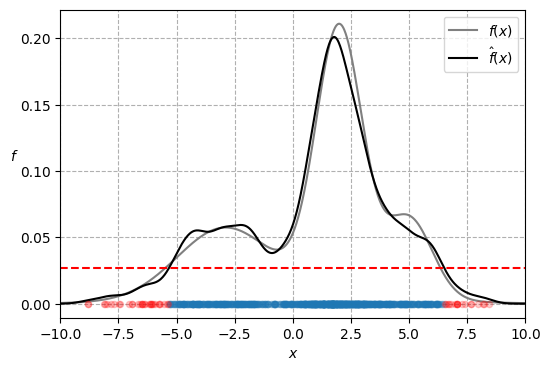

In [13]:
metrics_list = []
for r in r_grid:
    outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0], r=r)
    labels_pred = outlier_detector.predict(x_train[0])

    metric = pi_kf(x_train[0], x_train[0], labels_pred)
    metrics_list.append(metric)

argmin = np.argmin(metrics_list)
best_r = r_grid[argmin]

print(f"Najlepszy wskaźnik jakości (PI_kf): {metrics_list[argmin]:.6f}")
print(f"Dla 'r': {best_r}")


###
best_bandwidth = bandwidth_x[0] * best_bandwidth_multiplier
best_kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0], r=best_r)
scores = best_kde_outlier_detector.kde.pdf(x_grid)
labels_pred = best_kde_outlier_detector.predict(x_train[0])


# Plot
true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
plt.hlines(best_kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, s=20, alpha=0.2, zorder=2)
plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

## Wielokrotne eksperymenty

In [18]:
# metrics = np.empty((n_experiments,))
# for e in range(n_experiments):
#     kde_outlier_detector = KDEOutliersDetection().fit(x_train[e], bandwidth=bandwidth_x[e])
#     labels_pred = kde_outlier_detector.predict(x_train[e])
#     metrics[e] = pi_kf(x_train[e], x_train[e], labels_pred)

# print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (pi_kf): {np.mean(metrics):.6f} +- {np.std(metrics):.6f}")

### Dopasowanie $h$ na siatce

In [19]:
# fac_grid = [1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0]

# print(f"Mnożniki na siatce: {fac_grid}")

In [21]:
# best_metrics = np.empty((n_experiments,))
# for e in range(n_experiments):
#     metrics_list = []
#     for x_fac in fac_grid:
#         outlier_detector = KDEOutliersDetection().fit(x_train[e], bandwidth=bandwidth_x[e] * x_fac)
#         labels_pred = outlier_detector.predict(x_train[e])

#         metric = pi_kf(x_train[e], x_train[e], labels_pred)
#         metrics_list.append(metric)

#     best_metrics[e] = np.min(metrics_list)

# print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (pi_kf): {np.mean(best_metrics):.6f} +- {np.std(best_metrics):.6f}")

# Ujęcie warunkowe

## $y^*=0$

In [12]:
# y_star_neg = np.array([-2.0] * n_y)
y_star_0 = np.array([0.0] * n_y)
# y_star_pos = np.array([2.0] * n_y)

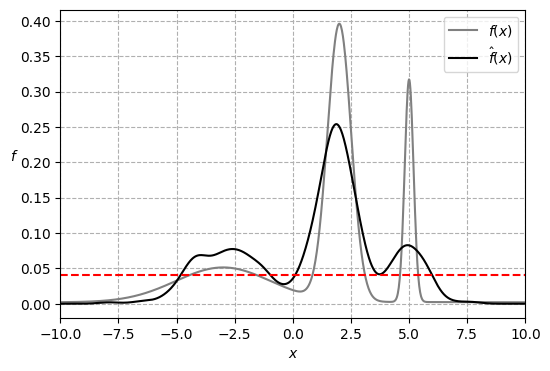

In [13]:
ckde_outlier_detector_0 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star_0,
                                                      bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores_0 = ckde_outlier_detector_0.ckde.pdf(x_grid)

true_dist1 = m_train1/m_train * norm.pdf(x_grid, loc=-3, scale=2.04)
true_dist2 = m_train2/m_train * norm.pdf(x_grid, loc=2, scale=0.51)
true_dist3 = m_train3/m_train * norm.pdf(x_grid, loc=5, scale=0.19)
true_dist4 = m_train4/m_train * norm.pdf(x_grid, loc=0, scale=16)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores_0, c="k", label="$\hat{f}(x)$")
plt.hlines(best_kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

In [14]:
labels_pred = ckde_outlier_detector_0.predict(x_train[0])

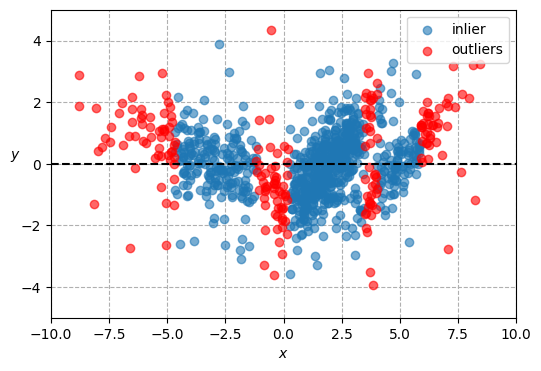

In [15]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.6, label="inlier")
plt.scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.6, c="red", label="outliers")
plt.hlines(y_star_0[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

## $y^* = y_i$

In [13]:
labels_pred = np.empty(m_train, dtype=np.int32)

for i in range(m_train):
    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                        bandwidth_x=bandwidth_x[0],
                                                        bandwidth_y=bandwidth_y[0])
    labels_pred[i] = ckde_outlier_detector.predict(x_train[0, [i]])

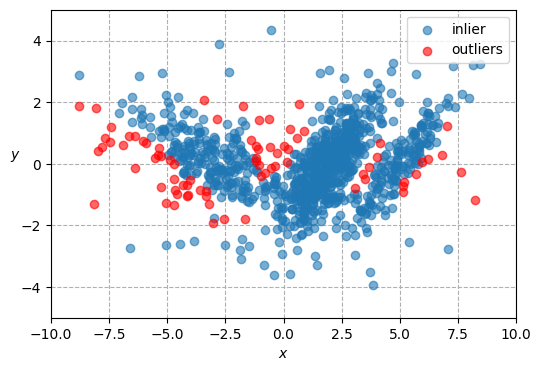

In [14]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.6, label="inlier")
plt.scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.6, c="red", label="outliers")
# plt.hlines(y_star_0[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()